In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso, Ridge, ElasticNet

## Load the dataset

In [3]:
def load_dataset(
    start_date: str = '1999-12-31',
    end_date: str = '2019-01-01') -> np.ndarray:
    '''
    Parameters
    ----------
    start_date: str, start date of the stock dataset, default = '1999-12-31'
    end_date: str, end date of the stock dataset, default = '2019-01-01'
    
    Returns
    -------
    np.ndarray
    '''
    data_raw = pd.read_csv('data_ml.csv', index_col=0)
    data_raw.reset_index(inplace=True)
    del data_raw['index']

    idx_date = data_raw.index[(data_raw['date'] > start_date) & (data_raw['date'] < end_date)].to_list()
    data_ml = data_raw.iloc[idx_date]
    
    return data_ml

In [4]:
data_ml = load_dataset()

In [5]:
features = data_ml.columns[2:95]
print(features)

Index(['Advt_12M_Usd', 'Advt_3M_Usd', 'Advt_6M_Usd', 'Asset_Turnover',
       'Bb_Yld', 'Bv', 'Capex_Ps_Cf', 'Capex_Sales', 'Cash_Div_Cf',
       'Cash_Per_Share', 'Cf_Sales', 'Debtequity', 'Div_Yld', 'Dps', 'Ebit_Bv',
       'Ebit_Noa', 'Ebit_Oa', 'Ebit_Ta', 'Ebitda_Margin', 'Eps', 'Eps_Basic',
       'Eps_Basic_Gr', 'Eps_Contin_Oper', 'Eps_Dil', 'Ev', 'Ev_Ebitda',
       'Fa_Ci', 'Fcf', 'Fcf_Bv', 'Fcf_Ce', 'Fcf_Margin', 'Fcf_Noa', 'Fcf_Oa',
       'Fcf_Ta', 'Fcf_Tbv', 'Fcf_Toa', 'Fcf_Yld', 'Free_Ps_Cf', 'Int_Rev',
       'Interest_Expense', 'Mkt_Cap_12M_Usd', 'Mkt_Cap_3M_Usd',
       'Mkt_Cap_6M_Usd', 'Mom_11M_Usd', 'Mom_5M_Usd', 'Mom_Sharp_11M_Usd',
       'Mom_Sharp_5M_Usd', 'Nd_Ebitda', 'Net_Debt', 'Net_Debt_Cf',
       'Net_Margin', 'Netdebtyield', 'Ni', 'Ni_Avail_Margin', 'Ni_Oa',
       'Ni_Toa', 'Noa', 'Oa', 'Ocf', 'Ocf_Bv', 'Ocf_Ce', 'Ocf_Margin',
       'Ocf_Noa', 'Ocf_Oa', 'Ocf_Ta', 'Ocf_Tbv', 'Ocf_Toa', 'Op_Margin',
       'Op_Prt_Margin', 'Oper_Ps_Net_Cf', 'Pb', 'Pe', 'Pt

## LASSO

In [7]:
y_penalized = data_ml['R1M_Usd'].values
X_penalized = data_ml[features].values
alphas = np.arange(1e-4, 1.0e-3, 1e-5)
lasso_res = {}

In [8]:
for alpha in alphas:
    lasso = Lasso(alpha=alpha)
    lasso.fit(X_penalized, y_penalized)
    lasso_res[alpha] = lasso.coef_

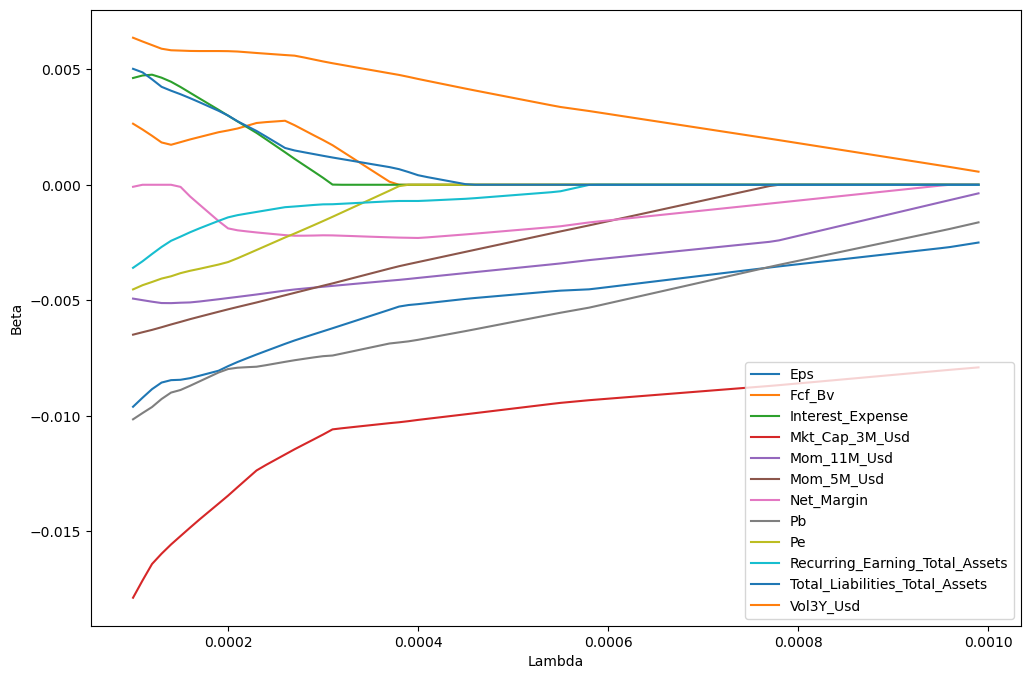

In [9]:
df_lasso_res = pd.DataFrame.from_dict(lasso_res).T
df_lasso_res.columns = features
predictors = (df_lasso_res.abs().sum() > 0.05)
df_lasso_res.loc[:,predictors].plot(
    xlabel = 'Lambda',
    ylabel = 'Beta',
    figsize = (12,8)
)
plt.show()

# Ridge Regression

In [11]:
n_alpha = 50
alphas = np.logspace(-2, 4, n_alpha)
ridge_res = {}

In [12]:
for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_penalized, y_penalized)
    ridge_res[alpha] = ridge.coef_

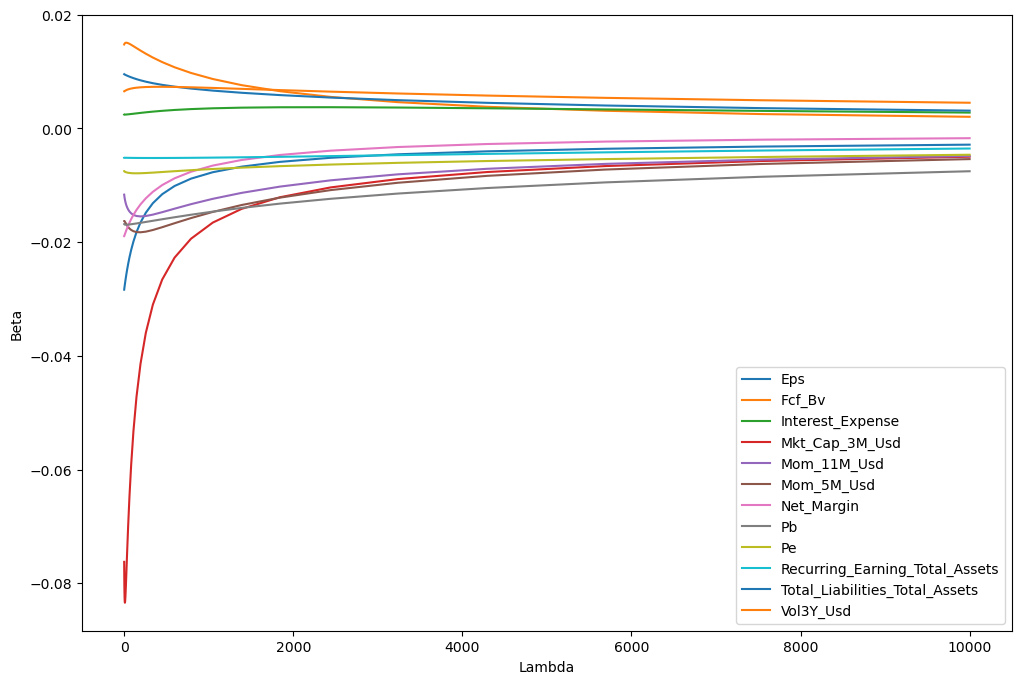

In [13]:
df_ridge_res = pd.DataFrame.from_dict(ridge_res).T
df_ridge_res.columns = features
df_ridge_res.loc[:,predictors].plot(
    xlabel = 'Lambda',
    ylabel = 'Beta',
    figsize = (12,8)
)
plt.show()

## Penalized Predictive Regression

In [15]:
separation_date = '2014-01-15'
idx_train = data_ml.index[(data_ml['date'] < separation_date)].to_list()
idx_test = data_ml.index[(data_ml['date'] >= separation_date)].to_list()
training_sample = data_ml.loc[idx_train]
testing_sample = data_ml.loc[idx_test]

In [16]:
y_penalized_training_sample = training_sample['R1M_Usd'].values
X_penalized_training_sample = training_sample[features].values
model = ElasticNet(alpha=0.1, l1_ratio=0.1)
fit_pen_pred = model.fit(X_penalized_training_sample, y_penalized_training_sample)

In [17]:
y_penalized_testing_sample = testing_sample['R1M_Usd'].values
X_penalized_testing_sample = testing_sample[features].values
mse = np.mean((fit_pen_pred.predict(X_penalized_testing_sample) - y_penalized_testing_sample)**2)
print(f'MSE: {mse}')

MSE: 0.036996958091850045


In [18]:
hitratio = np.mean(fit_pen_pred.predict(X_penalized_testing_sample)*y_penalized_testing_sample > 0)
print(f'Hit Ratio: {hitratio}')

Hit Ratio: 0.5460346399270738


## Interesting ideas to explore

1. Time-Series and Cross-Sectional Stock Return Forecasting: New Machine Learning Methods: https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3428095
2. Ridge Regularization: an Essential Concept in Data Science: https://arxiv.org/abs/2006.00371
3. Pockets of Predictability: https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3152386